## Test SPIM data CEBRA model

- Use CEBRA label contrastive learning on neural data from one fish
    - design model
    - convert SPIM data to usable format 
    - load data
    - fit with label
    - plot embeddings
    - try to predict stimulus presence
    - try to decode stimulus type (left/right spots)
        - create a discrete variable that labels the post-stimulus frames for right and left spots
        - This should inform the decoder to separate embedding states (which should vary between left and right spots)<br/><br/>

In [1]:
import cebra
import numpy as np
import matplotlib.pyplot as plt
import os
import h5py
import sklearn
from sklearn.model_selection import train_test_split
from pathlib import Path
import copy

In [2]:
### define globals ### 

# list of all data files
dat_files = ['/media/storage/DATA/lfads_export/f1_221027.h5',
             '/media/storage/DATA/lfads_export/f1_221103.h5',
             '/media/storage/DATA/lfads_export/f2_221103.h5',
             '/media/storage/DATA/lfads_export/f3_221103.h5']

global LABEL                   # brief description of model training label
global EXTRA_LABEL             # optional extra information to include in model name
global FILEPATH                # path to data file
global DATA_PATH               # path to experimental data
global MODELPATH_ROOT          # folder path for models folder
global MODELPATH_DATE          # specific path within models folder
global MODEL_VER               # append version to model name for when saving multiple repeats
global TIMESTEPS               # no. of neural timepoints to use
global ROIS                    # no. of ROIs to use 
global ITERS                   # model training iterations
global LOAD_DATA               # attempt to load pre-saved .npz data files
global SAVE_DATA               # save new .npz files when created
global LOAD_MODEL              # attempt to load model
global SAVE_MODEL              # save model to models folder
global STIM_TYPES              # dictionary of stim types to stim numbers
global STIMS                   # relevant stims for model
global STIM_MASKS              # remove? 
global TRAINING_TEST_SPLIT     # split fraction for embedding model
global STIM_LENGTH_FRAMES      # the length in frames of stimuli, assuming all stimuli have equal duration
global HALF_STIM_MASK          # only use the second half of stimuli for training the model

LABEL = 'spot'                                                          # set as '' for time-contrastive
EXTRA_LABEL = 'second-half-stims'
FILEPATH = dat_files[1]
DATA_PATH = '/home/tomh/Documents/projects/czebra/test_notebooks/data/'
MODELPATH_ROOT = '/home/tomh/Documents/projects/czebra/archived_models/'
MODELPATH_DATE = '230822/'
MODEL_VER = 8
TIMESTEPS = None                                                        # set as None to use all timepoints
ROIS = 10000
ITERS = 2000
LOAD_DATA = True
SAVE_DATA = False
LOAD_MODEL = False
SAVE_MODEL = True
STIM_TYPES = {'left_spot':0, 'right_spot':1,  \
              'open_loop_grating':2, 'closed_loop_grating':3}
STIMS = ['left_spot', 'right_spot']
STIM_MASKS = [['left_spot', 'right_spot']]
TRAINING_TEST_SPLIT = 0.8
STIM_LENGTH_FRAMES = 22
HALF_STIM_MASK = True

In [3]:
### define model ###

parameters = {'conditional':'time_delta',
              'max_iterations':ITERS,
              'batch_size':1024,
              'num_hidden_units':128,
              'weight_decay':1e-03,
              'rois':ROIS,
             }

cebra_stim_on_model = cebra.CEBRA(
    model_architecture='offset10-model',
    device='cuda_if_available',
    conditional=parameters['conditional'],
    temperature_mode='auto',
    min_temperature=0.1,
    time_offsets=10,
    max_iterations=parameters['max_iterations'],
    max_adapt_iterations=500,
    batch_size=parameters['batch_size'],
    learning_rate=1e-4,
    output_dimension=3,
    verbose=True,
    num_hidden_units=parameters['num_hidden_units'],
    hybrid=False,
    optimizer_kwargs=(('betas', (0.9, 0.999)), ('eps', 1e-08), ('weight_decay', parameters['weight_decay']), ('amsgrad', False))
    )
print(cebra_stim_on_model)

CEBRA(batch_size=1024, conditional='time_delta', learning_rate=0.0001,
      max_iterations=2000, model_architecture='offset10-model',
      num_hidden_units=128,
      optimizer_kwargs=(('betas', (0.9, 0.999)), ('eps', 1e-08),
                        ('weight_decay', 0.001), ('amsgrad', False)),
      output_dimension=3, temperature_mode='auto', time_offsets=10,
      verbose=True)


In [4]:
### load data for a single fish ###
# if LOAD == True, load pre-saved .npz file data. Otherwise,
# create this data as specified below and save it to .npz

##  params ##

# variables
stim_types = STIM_TYPES     # dict of all possible stims
stims = STIMS               # stim types chosen for analysis
timesteps = TIMESTEPS
rois = ROIS
stim_length_frames = STIM_LENGTH_FRAMES # used for selecting the second half of stimuli

start, stop = 0, timesteps
load_data = LOAD_DATA
save_data = SAVE_DATA

# paths
filepath = FILEPATH
filename = filepath.split('/')[-1][:-3] # fish and date only
data_folder = DATA_PATH
data_folder_HDD = '/media/storage/DATA/tom/'
filename_stim_pres_frames = f'{filename[-9:]}_stim_pres_frames.npz'
filename_dfof = f'{filename[-9:]}_dfof.npz'
filename_dfof_subset = f'{filename[-9:]}_dfof_subset.npz'

# if not loading data, but not wanting to overwrite saved data, save as a temp file
if not save_data and not load_data: 
    print(f"Producing temp files...")
    filename_dfof = f'{filename[-9:]}_dfof_TEMPORARY_DELETE.npz'
    filename_dfof_subset = f'{filename[-9:]}_dfof_subset_TEMPORARY_DELETE.npz'
    filename_stim_pres_frames = f'{filename[-9:]}_stim_pres_frames_TEMPORARY_DELETE.npz'


print("Accessing data...")

if load_data:
    
    ## load data ##
    
    # Attempt to load neural data from .npz, otherwise load from HDD .h5
    # Load small datasets from .npz files
    print("Loading data...")
    
    # neural
    try:
        key = "neural"
        ## loading full dataset from HDD
        # neural = cebra.load_data(filepath, key='rois/dfof')
        ## loading full dataset from SSD
        # neural = cebra.load_data(f"{data_folder}{filename_dfof}", key=key)
        # loading subset of dataset that was just created and saved
        neural = cebra.load_data(f"{data_folder}{filename_dfof_subset}", key=key)
        print("Neural data loaded")

    except:
        print(f"Could not neural data from file {data_folder}{filename_dfof_subset} under key {key}.")
        # try:
        #     neural = cebra.load_data(filepath, key='rois/dfof')
        #     print("Full neural data loaded from HDD file.")

        # except Exception as e:
        #     print("Could not load data.")
        #     print(e)
    
    # auxiliary variables
    stim_on_frames = cebra.load_data(f'{data_folder}{filename_stim_pres_frames}', key="stim_on_frames")
    print(f"Stimulus presentation frames loaded.")
    print("All data loaded.")

# end if

else:
    with h5py.File(filepath, 'r') as f:

            ## neural ##

            neural = f['rois']['dfof']
            print(f"Full neural dataset shape is: {neural.shape}")

            # subset neural by selecting first TIMESTEPS timesteps and random ROIS rois
            neural_indexes = np.sort(
                                np.random.choice(
                                            np.arange(neural.shape[1]), size=rois, replace=False
                                            )
                                )
            
            if timesteps:
                neural = np.array(neural[:timesteps, neural_indexes])
            else:
                neural = np.array(neural[:, neural_indexes])
                timesteps = neural.shape[0]

            print(f"Truncated dataset size: {neural.shape}")
            assert(neural.shape == (timesteps, rois))

            ## stimuli ##

            # get stimulus presentations
            stimuli = f['visuomotor']['presentations']
            stim_type = stimuli['stim_type'][:timesteps].astype(int)
            stim_on_fr = stimuli['onset_frame'][:timesteps].astype(int)
            stim_end_fr = stimuli['offset_frame'][:timesteps].astype(int)

            # initialise lists for the chosen stimuli
            (stim_pres_idx_list, stim_on_fr_list,
            stim_end_fr_list, stim_on_mask_list, stim_dur_list)  = [],[],[],[],[]


            # loop through chosen stimuli and find boolean masks for their 'on' frames
            for stim in stims:

                # convert stim name to stim number
                stim_num = stim_types[stim] 
                print(f'Attempting to parse stim: {stim}') 

                # find the presentation indexes for the specified stim type
                # must account for data index starting at 1
                this_stim_pres_indexes = np.where(np.isin(stim_type, stim_num + 1))[0]
                stim_pres_idx_list.append(this_stim_pres_indexes)

                # index stim onset frame numbers with the presentation indexes
                this_stim_on_frames = stim_on_fr[this_stim_pres_indexes]
                this_stim_on_frames = this_stim_on_frames[this_stim_on_frames < timesteps]

                # If taking only the second half of stimulus frames, increment the start frame
                # indexes by half the stimulus duration, to simulate the stimulus starting halfway
                # later than it actually does
                if HALF_STIM_MASK: 
                    print("Taking the second half of stimuli only.")
                    this_stim_on_frames = this_stim_on_frames + stim_length_frames/2
                stim_on_fr_list.append(this_stim_on_frames)

                # index stim end frame numbers with the presentation indexes
                this_stim_end_frames = stim_end_fr[this_stim_pres_indexes]
                this_stim_end_frames = this_stim_end_frames[this_stim_end_frames < timesteps]
                stim_end_fr_list.append(this_stim_end_frames)

                # create a boolean mask of stimulus presentation frames (1 == stimulus on, 0 == stimulus off)
                this_stim_on_mask = np.zeros(neural.shape[0]).astype(int)
                this_stim_on_mask[[this_stim_on_frames, this_stim_end_frames]] = 1
                
                # perform bitwise XOR operation on consecutive elements of stim_on_mask. This will convert all 
                # but stim_off frame to 1s. Combining with "OR stim_on_mask" will also include the stim_off frame
                this_stim_on_mask = np.bitwise_xor.accumulate(this_stim_on_mask) | this_stim_on_mask
                stim_on_mask_list.append(this_stim_on_mask)

                # find duration (in frames) of each presentation of the stimulus
                # recording rate is 5 Hz
                stim_dur_list.append(this_stim_end_frames - this_stim_on_frames)

                # assert shapes
                print(f"Label shape: {stim_on_mask_list[0].shape}")
                assert(stim_on_mask_list[0].size == neural.shape[0])

                print(f'Stim type {stim} parsed successfully.')

            ## save data ##
            print("Saving data...")
            stim_on_mask_dataset = np.column_stack(stim_on_mask_list[:])

            assert(stim_on_mask_dataset.shape == (neural.shape[0], len(stims)))
            assert(neural.shape == (timesteps, rois))

            np.savez(f'{data_folder}{filename_stim_pres_frames}', stim_on_frames=stim_on_mask_dataset)
            print(f"Stim presentation dataset saved.")
            np.savez(f"{data_folder}{filename_dfof_subset}", neural=neural)
            print(f"Neural dataset saved.")
            print(f"All datasets saved.")

            ## load data ##
            # Attempt to load neural data from .npz, otherwise load from HDD .h5
            # Load small datasets from .npz files
            print("Loading data...")
            
            # neural
            try:
                key = "neural"
                ## loading full dataset from HDD
                # neural = cebra.load_data(filepath, key='rois/dfof')
                ## loading full dataset from SSD
                # neural = cebra.load_data(f"{data_folder}{filename_dfof}", key=key)
                # loading subset of dataset that was just created and saved
                neural = cebra.load_data(f"{data_folder}{filename_dfof_subset}", key=key)
                print("Neural data loaded")

            except:
                print(f"Could not neural data from file {data_folder}{filename_dfof_subset} under key {key}.")
                try:
                    neural = cebra.load_data(filepath, key='rois/dfof')
                    print("Full neural data loaded from HDD file.")

                except Exception as e:
                    print("Could not load data.")
                    print(e)
            
            # auxiliary variables
            stim_on_frames = cebra.load_data(f'{data_folder}{filename_stim_pres_frames}', key="stim_on_frames")
            print(f"Stimulus presentation frames loaded.")
            print("All data loaded.")

# end else

# format the discrete variable
# left spot == 1, right spot == 2, no stimulus == 0 
left_spot, right_spot = stim_on_frames[:,0], stim_on_frames[:,1]
right_spot = np.multiply(right_spot, 2)
discrete = np.add(left_spot, right_spot)

# separate data into training and test
training_test_split = TRAINING_TEST_SPLIT
split_idx = int(np.round(neural.shape[0] * training_test_split))
neural_train, neural_test = neural[:split_idx, :], neural[split_idx:, :]
discrete_train, discrete_test = discrete[:split_idx], discrete[split_idx:]

Accessing data...
Loading data...
Neural data loaded
Stimulus presentation frames loaded.
All data loaded.


In [5]:
### load, fit, and save model ###
# if LOAD_MODEL == True, load the specified model. Otherwise, fit the model
# and additionally save it if SAVE_MODEL == True

modelpath_root = MODELPATH_ROOT
modelpath_date = MODELPATH_DATE

# create model name and full model path
model_name = 'f1_221103_spot-label_10000rois_2000iters_128hidden_1e-4L2'
model_name = f"{filename}_{LABEL}{'-label' if parameters['conditional'] == 'time_delta' else 'time'}_" + \
    f"{EXTRA_LABEL+'_' if EXTRA_LABEL else ''}" + \
    f"{ROIS}rois_{ITERS}iters_{parameters['num_hidden_units']}hidden_{parameters['weight_decay']}L2_" + \
    f"{TRAINING_TEST_SPLIT}train"
full_model_path = f"{modelpath_root}{modelpath_date}{model_name}/{model_name}_{MODEL_VER}.pt"


if LOAD_MODEL:

    ## load ##

    print("Loading model...")
    cebra_stim_on_model = cebra.CEBRA.load(full_model_path)
    print("Model loaded.")

    if SAVE_MODEL:

        ## save ##
        print("Saving model...")
        cebra_stim_on_model.save(full_model_path)
        print("Model saved.")

else:

    ## fit ## 

    print("Fitting model...")
    print(cebra_stim_on_model)


    cebra_stim_on_model.fit(neural_train, discrete_train)
    print("Model fit.")


if SAVE_MODEL and not LOAD_MODEL:
    
    ## save ##

    print("Saving model...")
    # create the directory if it does not already exist (and continue if it does)
    Path(f"{modelpath_root}{modelpath_date}{model_name}").mkdir(parents=True, exist_ok=True)
    cebra_stim_on_model.save(full_model_path)
    print("Model saved.")


Fitting model...
CEBRA(batch_size=1024, conditional='time_delta', learning_rate=0.0001,
      max_iterations=2000, model_architecture='offset10-model',
      num_hidden_units=128,
      optimizer_kwargs=(('betas', (0.9, 0.999)), ('eps', 1e-08),
                        ('weight_decay', 0.001), ('amsgrad', False)),
      output_dimension=3, temperature_mode='auto', time_offsets=10,
      verbose=True)


pos:  0.0025 neg:  6.8276 total:  6.8301 temperature:  0.8117: 100%|██████████| 2000/2000 [04:58<00:00,  6.69it/s]

Model fit.
Saving model...
Model saved.


<Axes3D: title={'center': 'Test embedding'}>

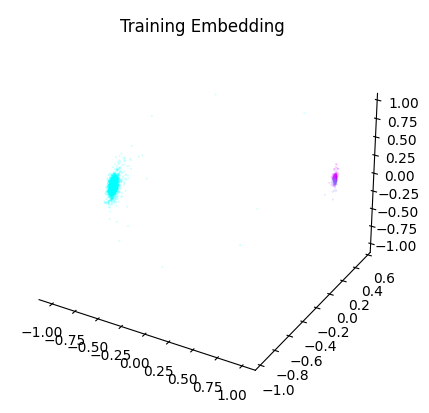

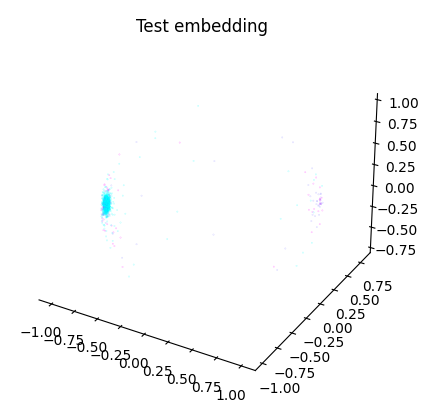

In [6]:
### generate/plot embeddings ###

# CEBRA's plot_embedding function is bugged
# fig = plt.figure(figsize=(6,12)
# ax1 = plt.subplot(211)
# ax2 = plt.subplot(212)

# trained embedding
embedding_train = cebra_stim_on_model.transform(neural_train)
cebra.plot_embedding(embedding=embedding_train, embedding_labels=discrete_train, cmap='cool', title="Training Embedding")

# test embedding
embedding_test = cebra_stim_on_model.transform(neural_test)
cebra.plot_embedding(embedding=embedding_test, embedding_labels=discrete_test, cmap='cool', title="Test embedding")

<Axes: xlabel='Steps', ylabel='Temperature'>

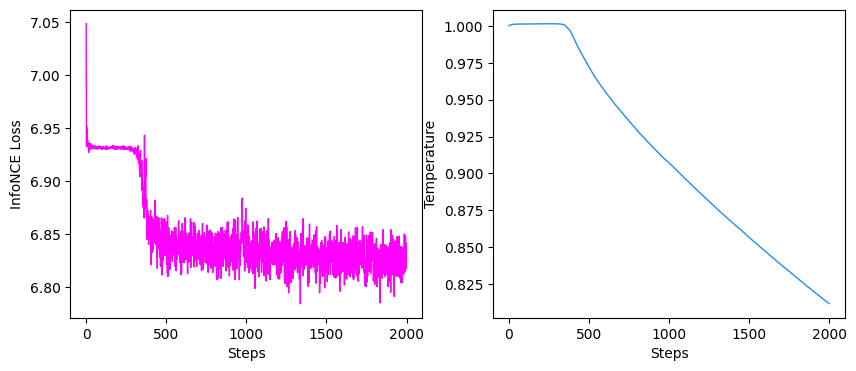

In [7]:
### plot loss and temperature ###

fig = plt.figure(figsize=(10,4))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)

cebra.plot_loss(cebra_stim_on_model, ax=ax1)
cebra.plot_temperature(cebra_stim_on_model, ax=ax2)

In [8]:
### Decode ###
## rewritten to train on training set ##

decoder = cebra.KNNDecoder()

decoder.fit(embedding_train, discrete_train)

predictions = decoder.predict(embedding_test)

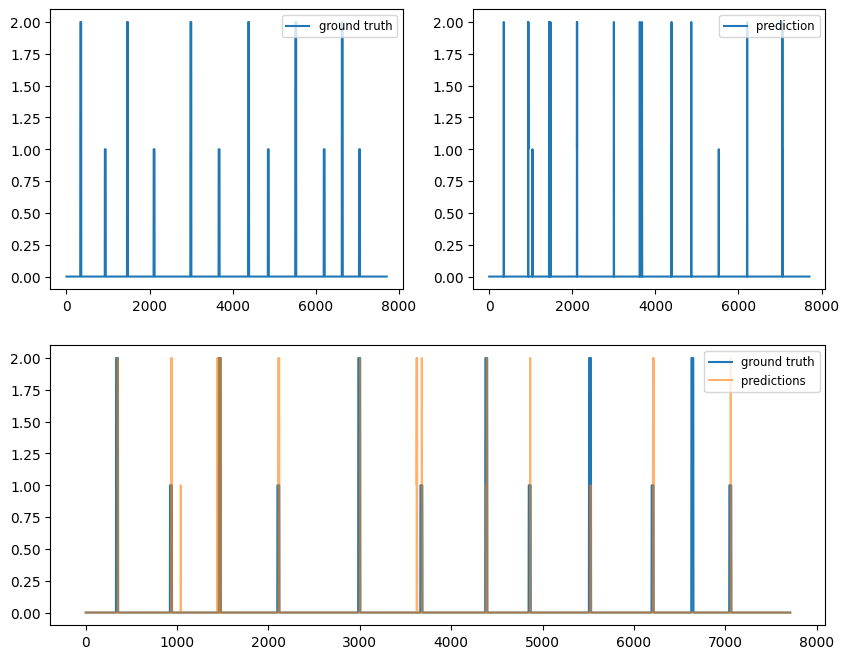

In [9]:
### visualise ###

fig = plt.figure(figsize=(10,8))
ax1 = plt.subplot(2,2,1)
ax2 = plt.subplot(2,2,2)
ax3 = plt.subplot(2,1,2)

ax1.plot(discrete_test, label='ground truth')
# ax1.plot(predictions, label='prediction')
ax1.legend(loc='upper right', fontsize='small')

ax2.plot(predictions, label='prediction')
ax2.legend(loc='upper right', fontsize='small')

ax3.plot(discrete_test, label='ground truth')
ax3.plot(predictions, label='predictions', alpha=0.6)
ax3.legend(loc='upper right', fontsize='small')


In [10]:
### evaluate decoder performance - f1 score ###
# Also provide a lenient f1-score (where any prediction of a stimulus within 
# the stimulus duration counts as a fully accurate predictions)

## convert left and right spots to the same value (1) ## 

# find the test subset
training_test_split = TRAINING_TEST_SPLIT   
split_idx = int(np.round(neural.shape[0] * training_test_split))
# index stim_on mask to restrict data to the test subset
left_spot, right_spot = stim_on_frames[split_idx:,0], stim_on_frames[split_idx:,1]
# combine left and right spot stim_on mask
discrete_test_f1 = np.add(left_spot, right_spot)

# convert predictions to also all be the same value
idx_to_replace = np.where(np.isin(predictions, 2))[0]
predictions_f1 = np.copy(predictions)
predictions_f1[idx_to_replace] = 1

## calculate f1-score ##

f1_score = sklearn.metrics.f1_score(discrete_test_f1, predictions_f1)

## calculate lenient f1-score ##

stim_length = STIM_LENGTH_FRAMES
leniency_range = stim_length*2
predictions_f1_lenient = np.copy(predictions_f1)

# find the indexes where a prediction was made
prediction_made = np.where(np.isin(predictions_f1, 1))[0]

# for each index
for idx in prediction_made:

    # check if this is a correct prediction (ground-truth also 1)
    if discrete_test_f1[idx] == 1:
        # for the leniency_range timepoints around the stimulus, copy any 1s from the ground truth to predictions
        upper_bound, lower_bound = np.ceil(idx+leniency_range/2).astype(int), np.ceil(idx-leniency_range/2).astype(int)
        predictions_f1_lenient[lower_bound:upper_bound] = discrete_test_f1[lower_bound:upper_bound]

# find the lenient f1-score
lenient_f1_score = sklearn.metrics.f1_score(discrete_test_f1, predictions_f1_lenient)


## report f1-score ##

print(f"Strict f1-score:  {f1_score:.3f}\nLenient f1-score: {lenient_f1_score:.3f}")

Strict f1-score:  0.313
Lenient f1-score: 0.938


In [11]:
discrete_test_f1[2000] == 1

False

In [12]:
## calculate lenient f1-score ##

stim_length = 22
leniency_range = stim_length*2
predictions_f1_lenient = predictions_f1

# find the indexes where a prediction was made
prediction_made = np.where(np.isin(predictions_f1, 1))[0]

# for each index
for idx in prediction_made:

    # check if this is a correct prediction (ground-truth also 1)
    if discrete_test_f1[idx] == 1:
        # for the leniency_range timepoints around the stimulus, copy any 1s from the ground truth to predictions
        upper_bound, lower_bound = np.ceil(idx+leniency_range/2).astype(int), np.ceil(idx-leniency_range/2).astype(int)
        print(upper_bound, lower_bound)
        predictions_f1_lenient[lower_bound:upper_bound] = discrete_test_f1[lower_bound:upper_bound]

# find the lenient f1-score
lenient_f1_score = sklearn.metrics.f1_score(discrete_test_f1, predictions_f1_lenient)
print(lenient_f1_score)


373 329
958 914
959 915
960 916
961 917
962 918
1494 1450
1495 1451
1497 1453
2133 2089
2134 2090
2135 2091
2136 2092
2137 2093
2138 2094
2139 2095
3021 2977
3022 2978
3023 2979
3024 2980
3699 3655
3700 3656
3701 3657
3702 3658
4403 4359
4409 4365
4410 4366
4411 4367
4412 4368
4413 4369
4884 4840
4885 4841
4886 4842
5545 5501
5546 5502
5547 5503
5548 5504
5549 5505
6228 6184
6229 6185
6230 6186
6231 6187
6232 6188
6233 6189
6234 6190
7079 7035
7080 7036
7081 7037
7082 7038
7083 7039
7084 7040
0.9379844961240309


In [13]:
f1_score, lenient_f1_score

(0.31288343558282206, 0.9379844961240309)

In [14]:
discrete_test_f1[920:950], predictions_f1[920:950]



(array([0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 0, 0, 0, 0, 0, 0]))

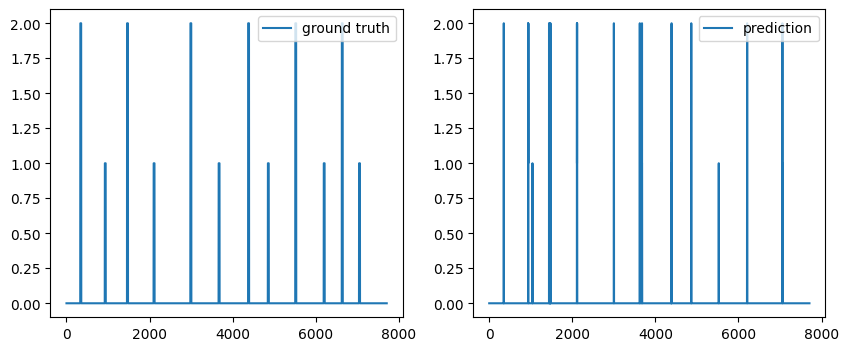

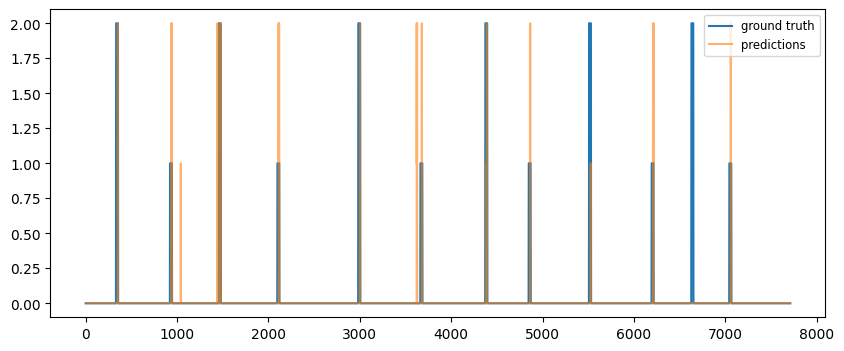

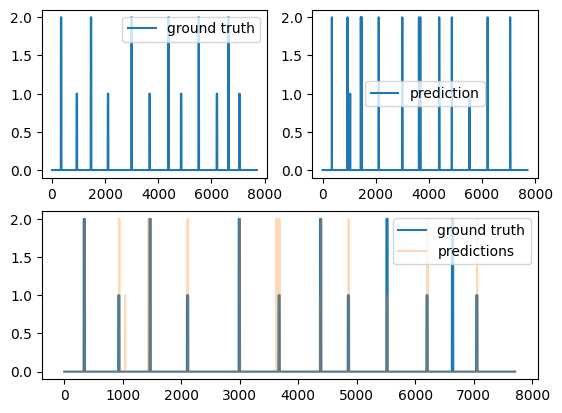

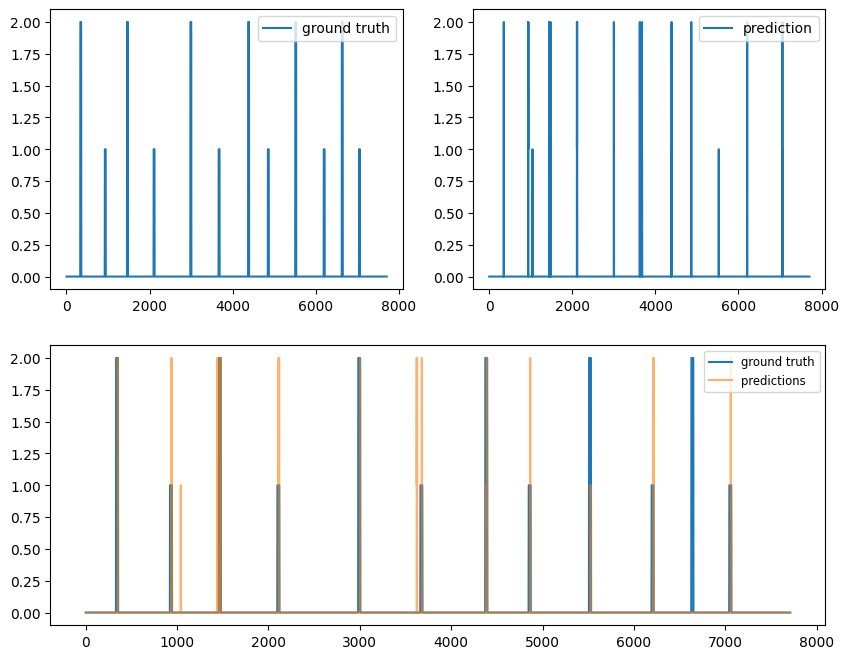

In [15]:
### Visualise ### 
fig, ((ax1, ax2)) = plt.subplots(1,2, figsize=(10,4))
ax1.plot(discrete_test, label='ground truth')
# ax1.plot(predictions, label='prediction')
ax1.legend()

ax2.plot(predictions, label='prediction')
ax2.legend()

fig2, ax3 = plt.subplots(1,1, figsize=(10,4))
ax3.plot(discrete_test, label='ground truth')
ax3.plot(predictions, label='predictions', alpha=0.6)
ax3.legend(loc='upper right', fontsize='small')


fig = plt.figure()
ax1 = plt.subplot(2,2,1)
ax2 = plt.subplot(2,2,2)
ax3 = plt.subplot(2,1,2)

ax1.plot(discrete_test, label='ground truth')
# ax1.plot(predictions, label='prediction')
ax1.legend()

ax2.plot(predictions, label='prediction')
ax2.legend()

# fig2, ax3 = plt.subplots(1,1, figsize=(5,4))
ax3.plot(discrete_test, label='ground truth')
ax3.plot(predictions, label='predictions', alpha=0.3)
ax3.legend()


####

fig = plt.figure(figsize=(10,8))
ax1 = plt.subplot(2,2,1)
ax2 = plt.subplot(2,2,2)
ax3 = plt.subplot(2,1,2)

ax1.plot(discrete_test, label='ground truth')
# ax1.plot(predictions, label='prediction')
ax1.legend()

ax2.plot(predictions, label='prediction')
ax2.legend()

ax3.plot(discrete_test, label='ground truth')
ax3.plot(predictions, label='predictions', alpha=0.6)
ax3.legend(loc='upper right', fontsize='small')
